In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matching.glema.common.utils.plot_utils import ColorScheme

In [2]:
size_summary_file = "./generation_meta/dpdf/size_summary.csv"
benchmark_file = "./generation_meta/dpdf/benchmark.csv"

In [3]:
def transform_project( x: str, prefix="dpdf" ):
    x = x.lower()
    x = x.replace( " ", "_" )
    x = x.replace( ".", "" )
    return f"{prefix}-{x}"

In [4]:
df_sizes = pd.read_csv( size_summary_file )
df_sizes[ 'project' ] = df_sizes[ 'project' ].apply( transform_project )
df_benchmarks = pd.read_csv( benchmark_file )
df_benchmarks.rename( columns={ "name": "project" }, inplace=True )

In [5]:
df_benchmarks

,project,process_name,process_count,process_time_sec,total_time_sec
0,dpdf-maven-cuke4duke-jump-start,LoadPatternFileModule,0,0.000,0.000
1,dpdf-maven-cuke4duke-jump-start,ReadPatternsModule,1,0.007,0.007
2,dpdf-maven-cuke4duke-jump-start,AttachPatternsToContext,2,0.008,0.015
3,dpdf-maven-cuke4duke-jump-start,LoadDatasetFileModule,3,0.000,0.015
4,dpdf-maven-cuke4duke-jump-start,GenerateCpgModule,4,0.427,0.442
...,...,...,...,...,...
1939,dpdf-petals-studio,ComputeRecordInteractionsModule,10,0.032,193.465
1940,dpdf-petals-studio,CpgFilterEdgesModule,11,0.095,193.560
1941,dpdf-petals-studio,MarkPatternsModule,12,0.003,193.563
1942,dpdf-petals-studio,PersistCpgModule,13,0.666,194.229


In [6]:
df_sizes

,project,bytes
0,dpdf-glowing-octo-cyril,0
1,dpdf-mp,4
2,dpdf-mario,9
3,dpdf-primefaces-webflow-spring-hibernate-pom,23
4,dpdf-testrepo,29
...,...,...
14312,dpdf-xtext,129178615
14313,dpdf-liferay-portal,140481262
14314,dpdf-jdk7u-jdk,144199616
14315,dpdf-ikvm-openjdk,162612156


In [7]:
process_groups: dict[ str, list[ str ] ] = {
    "Fetching": [
        "LoadPatternFileModule",
        "ReadPatternsModule",
        "AttachPatternsToContext",
        "LoadDatasetFileModule"
    ],
    "Translating": [
        "GenerateCpgModule",
        "TranslationToGraphModule"
    ],
    "Processing": [
        "RemoveBlacklistElementsModule",
        "FilterInternalScopeModule",
        "PropagateRecordScopeModule",
        "ComputeRecordPathsModule",
        "ComputeRecordInteractionsModule",
        "CpgFilterEdgesModule"
    ],
    "Persisting": [
        "MarkPatternsModule",
        "PersistCpgModule"
    ]
}

In [8]:
# Create a mapping from each process name to its group
process_to_group = { }
for group, processes in process_groups.items():
    for proc in processes:
        process_to_group[ proc ] = group

# Map process names in df to their respective group
df_benchmarks[ 'process_group' ] = df_benchmarks[ 'process_name' ].map( process_to_group )

# Convert process_time_sec to a numeric type (in case it's read as a string)
df_benchmarks[ 'process_time_sec' ] = pd.to_numeric( df_benchmarks[ 'process_time_sec' ], errors='coerce' )

# Group by "name" and "group", summing the process_time_sec, then unstack so each group is a column
df = df_benchmarks.groupby( [ 'project', 'process_group' ] )[ 'process_time_sec' ].sum().unstack(
    fill_value=0 ).reset_index()
group_cols = list( process_groups.keys() )  # ['fetching', 'translating', 'processing', 'persisting']
df = df[ (df[ group_cols ] != 0).all( axis=1 ) ]

df = pd.merge( df, df_sizes, on='project' )
df

,project,Fetching,Persisting,Processing,Translating,bytes
0,dpdf-3taps-java-client,0.005,0.070,0.087,0.677,44936
1,dpdf-a7b36ass,0.008,0.246,0.493,2.402,91231
2,dpdf-accent,0.004,0.109,0.082,0.534,55586
3,dpdf-agetac-ng,0.007,0.219,0.484,5.593,265963
4,dpdf-akka-javaee6-integracia,0.005,0.080,0.061,1.272,65514
...,...,...,...,...,...,...
117,dpdf-uk-ejemplos,0.006,0.132,0.431,3.254,80042
118,dpdf-vogella,0.008,0.794,7.978,233.007,5000382
119,dpdf-wayback,0.052,0.466,6.727,249.809,1890045
120,dpdf-whartoneventscheduler,0.007,0.097,0.050,0.417,16634


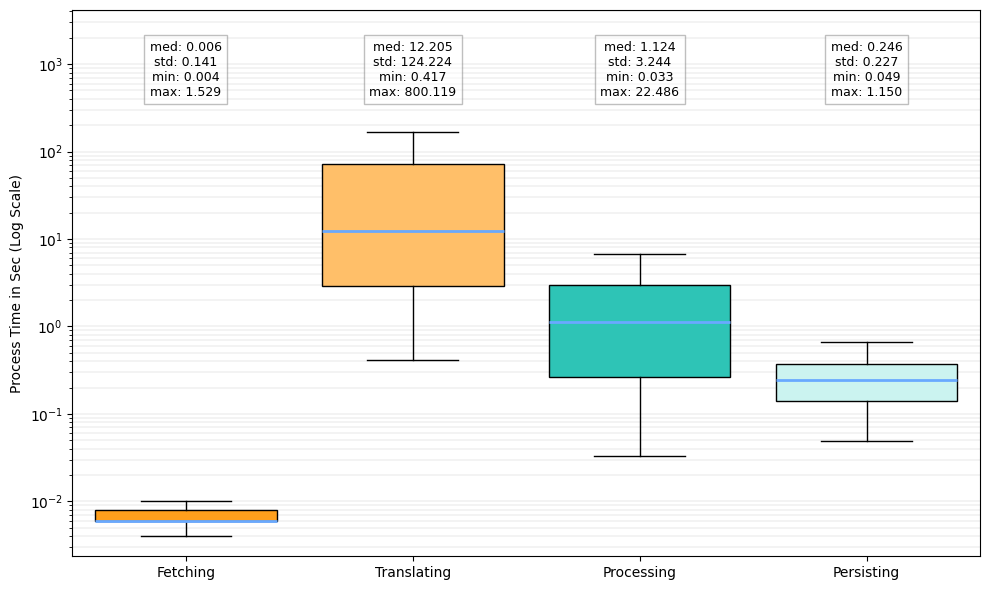

In [9]:
custom_colors = [ ColorScheme.PRIMARY, ColorScheme.PRIMARY_LIGHT, ColorScheme.SECONDARY, ColorScheme.SECONDARY_LIGHT ]

# Define the group order
groups = process_groups.keys()

# Prepare data for boxplot: a list of series corresponding to each group
data = [ df[ group ].dropna() for group in groups ]

# Create the boxplot with a log scale on the y-axis
fig, ax = plt.subplots( figsize=(10, 6) )
bp = ax.boxplot( data,
                 patch_artist=True,
                 tick_labels=groups,
                 showfliers=False,
                 medianprops=dict( color=ColorScheme.HIGHLIGHT, linewidth=2 ),
                 widths=0.8 )

# Apply the custom colors to each box
for patch, color in zip( bp[ 'boxes' ], custom_colors ):
    patch.set_facecolor( color )

# Set y-axis to log scale
ax.set_yscale( 'log' )

# Compute the global maximum across all groups
all_data = pd.concat( data )
global_max = all_data.max()

# Manually set the top limit to 30% above the global max
# (Adjust as needed if your data is very spread out)
ax.set_ylim( top=global_max * 1.3 * 4 )

# Add grid lines on the y-axis to act as a scale line
ax.yaxis.grid( True, which='both', linewidth=0.2 )

# Calculate and annotate statistics for each group
for i, group in enumerate( groups ):
    group_data = df[ group ].dropna()
    med_val = group_data.median()
    std_val = group_data.std()
    min_val = group_data.min()
    max_val = group_data.max()

    # Create annotation text
    annotation_text = (f"med: {med_val:.3f}\n"
                       f"std: {std_val:.3f}\n"
                       f"min: {min_val:.3f}\n"
                       f"max: {max_val:.3f}")

    # Position annotation: For log scale, multiply the max value by a factor
    x_pos = i + 1
    #y_pos = max_val * 1.05  # 10% above the max value
    y_pos = 400
    ax.text( x_pos, y_pos, annotation_text,
             ha='center', va='bottom', fontsize=9,
             bbox=dict( facecolor='white', alpha=0.5, edgecolor='gray' ) )

ax.set_ylabel( "Process Time in Sec (Log Scale)" )
plt.tight_layout()
#plt.show()

plt.savefig( "plots/benchmark_groups" )

In [10]:
df

,project,Fetching,Persisting,Processing,Translating,bytes
0,dpdf-3taps-java-client,0.005,0.070,0.087,0.677,44936
1,dpdf-a7b36ass,0.008,0.246,0.493,2.402,91231
2,dpdf-accent,0.004,0.109,0.082,0.534,55586
3,dpdf-agetac-ng,0.007,0.219,0.484,5.593,265963
4,dpdf-akka-javaee6-integracia,0.005,0.080,0.061,1.272,65514
...,...,...,...,...,...,...
117,dpdf-uk-ejemplos,0.006,0.132,0.431,3.254,80042
118,dpdf-vogella,0.008,0.794,7.978,233.007,5000382
119,dpdf-wayback,0.052,0.466,6.727,249.809,1890045
120,dpdf-whartoneventscheduler,0.007,0.097,0.050,0.417,16634


/var/folders/zt/_0dhw2k11qq_vdzd29cd_xmh0000gn/T/ipykernel_81731/3798071139.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby( 'byte_interval' )[ groups ].median()


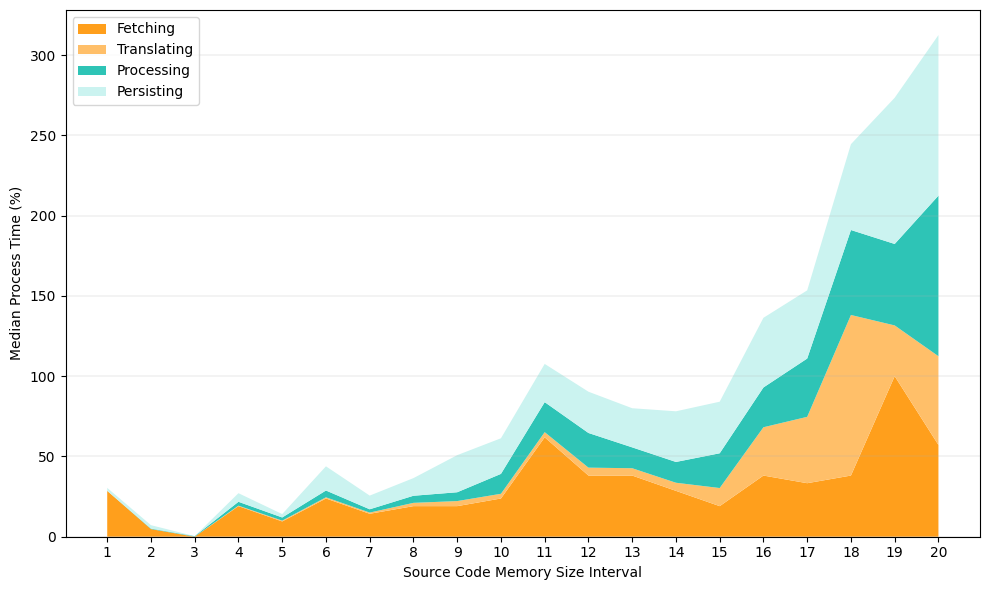

In [11]:
groups = list( process_groups.keys() )

# Create 10 equal-width bins for the "bytes" column
num_bins = 20
df[ 'byte_interval' ] = pd.qcut( df[ 'bytes' ], q=num_bins )

# Group by the byte interval and compute the average process times for each process group
grouped = df.groupby( 'byte_interval' )[ groups ].median()

normalized = grouped.copy()
for col in normalized.columns:
    min_val = normalized[ col ].min()
    max_val = normalized[ col ].max()
    # Avoid division by zero if all values are equal
    if max_val - min_val > 0:
        normalized[ col ] = (normalized[ col ] - min_val) / (max_val - min_val)
    else:
        normalized[ col ] = 0.0

# Compute the midpoint for each byte interval to serve as the x-axis values.
#mid_points = normalized.index.map( lambda interval: (interval.left + interval.right) / 2 )

# Convert normalized values to percentages
normalized_pct = normalized * 100
# Create x-axis values as bin numbers 1, 2, ..., number of bins
x = np.arange( 1, len( normalized_pct ) + 1 )

# Extract values for each process group from the grouped DataFrame
fetching = normalized_pct[ groups[ 0 ] ].values
translating = normalized_pct[ groups[ 1 ] ].values
processing = normalized_pct[ groups[ 2 ] ].values
persisting = normalized_pct[ groups[ 3 ] ].values

# Create the stackplot
fig, ax = plt.subplots( figsize=(10, 6) )
#ax.set_yscale( 'log' )

ax.stackplot( x, fetching, translating, processing, persisting,
              labels=groups, colors=custom_colors )

ax.yaxis.grid( True, which='both', linewidth=0.2 )
ax.set_xlabel( "Source Code Memory Size Interval" )
ax.set_ylabel( "Median Process Time (%)" )
ax.legend( loc='upper left' )

# Set a specific number of x-axis ticks.
desired_num_ticks = 20  # Change this to the number of ticks you want
ticks = np.linspace( 1, num_bins, desired_num_ticks, dtype=int )
ax.set_xticks( ticks )
ax.set_xticklabels( ticks )

plt.tight_layout()

plt.savefig( "plots/benchmark_scaling" )